In [ ]:
!pip install datasets
# Import required libraries
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Prepare dataset
def prepare_data(texts, tokenizer, seq_length):
    tokenized_texts = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, add_special_tokens=True)
    input_ids = tokenized_texts["input_ids"]

    X, y = [], []
    for sentence in input_ids:
        for i in range(seq_length, len(sentence)):
            X.append(sentence[i-seq_length:i])
            y.append(sentence[i])

    # Pad sequences for consistent length
    X = pad_sequence(X, batch_first=True, padding_value=tokenizer.pad_token_id)
    y = torch.tensor(y)

    return X, y


In [ ]:
# Define tokenizer and vocab
class SimpleTokenizer:
    def __init__(self):
        self.vocab = {}
        self.pad_token_id = 0

    def fit(self, texts):
        unique_tokens = set(word for text in texts for word in text.split())
        self.vocab = {word: idx + 1 for idx, word in enumerate(unique_tokens)}  # Reserve 0 for padding
        self.vocab["<PAD>"] = self.pad_token_id

    def encode(self, text):
        return [self.vocab.get(word, self.pad_token_id) for word in text.split()]

    def __call__(self, texts, return_tensors="pt", truncation=True, padding=True, add_special_tokens=False):
        encoded = [self.encode(text) for text in texts]
        max_length = max(len(seq) for seq in encoded)
        padded = [seq + [self.pad_token_id] * (max_length - len(seq)) for seq in encoded]
        return {"input_ids": torch.tensor(padded)}


In [ ]:
# Initialize tokenizer
tokenizer = SimpleTokenizer()

# Load dataset and tokenize
print("Loading dataset...")
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
texts = dataset[:1000]["text"]  # Use a subset for efficiency
tokenizer.fit(texts)

seq_length = 50
X, y = prepare_data(texts, tokenizer, seq_length)


Loading dataset...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [ ]:
# Split dataset into train and validation sets
print("Splitting dataset...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


Splitting dataset...


In [ ]:
# Define GRU Model
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        logits = self.fc(gru_out[:, -1, :])  # Use the last hidden state
        return logits


In [ ]:
# Initialize the model
print("Initializing model...")
vocab_size = len(tokenizer.vocab)
embedding_dim = 128
hidden_dim = 256

model = GRUModel(vocab_size, embedding_dim, hidden_dim)


Initializing model...


In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)


In [ ]:

# Training loop
print("Starting training...")
epochs = 3
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X, batch_y

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=-1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X, batch_y

            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y).item()
            preds = outputs.argmax(dim=-1)
            val_correct += (preds == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")


Starting training...
Epoch 1/3, Train Loss: 0.7304, Train Acc: 0.9125, Val Loss: 0.6517, Val Acc: 0.9163
Epoch 2/3, Train Loss: 0.5947, Train Acc: 0.9179, Val Loss: 0.6603, Val Acc: 0.9175
Epoch 3/3, Train Loss: 0.5647, Train Acc: 0.9190, Val Loss: 0.6544, Val Acc: 0.9186


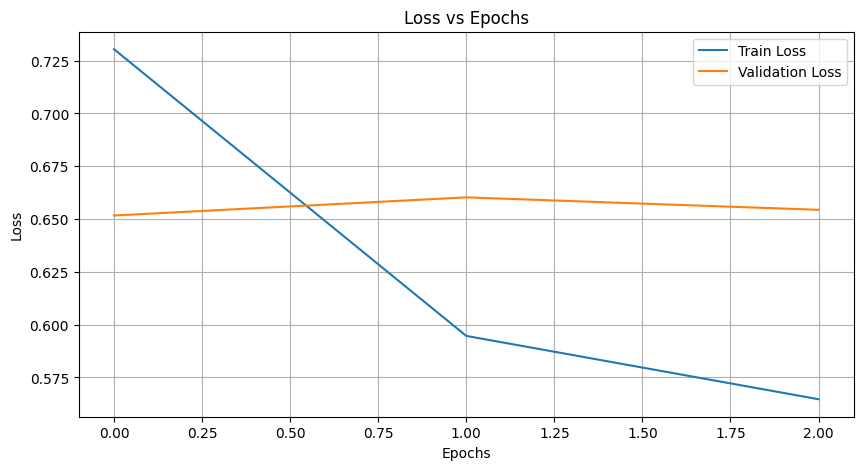

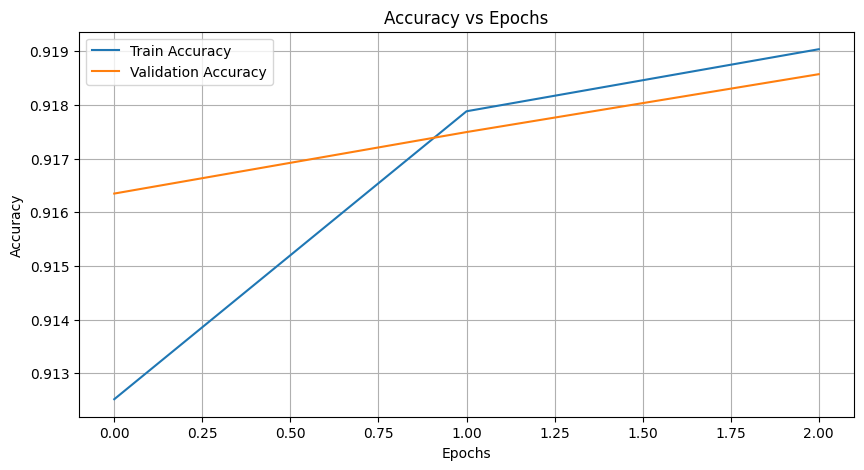

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()